## Topic modelling with ngrams

Генерация ngram с помощью gensim Phraser.

In [13]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from termcolor import colored
import glob
from nltk.stem.wordnet import WordNetLemmatizer

import pyLDAvis.gensim
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
import matplotlib.pyplot as plt
%matplotlib inline

import tm_functions

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Фиксирование рандома и прочее
np.random.seed(42)
lemma = WordNetLemmatizer()
ru_stop = stopwords.words('russian')

### Обработка текста

In [3]:
data = pd.DataFrame()
for df in glob.glob('data/*.txt.gz'):
    data = data.append(pd.read_csv(df, sep='\t', encoding='utf-8', header=None))
    
data.columns = ['id', 'url', 'title', 'text']
# есть немного дубликатов
data = data.drop_duplicates('url')

In [4]:
print(f'{data.shape[0]} строк')

70726 строк


In [5]:
data_original = data.copy()

Для начала токенизируем тексты.

In [6]:
%%time
data.loc[:, 'cleaned_text'] = data['text'].apply(lambda x: tm_functions.text_to_words(x, return_tokenized=False, lemmatizer=lemma, stop_words=ru_stop))

Wall time: 1min 17s


In [9]:
%%time
data.loc[:, 'tokenized_text'] = data['text'].apply(lambda x: tm_functions.text_to_words(x, lemmatizer=lemma, stop_words=ru_stop, return_tokenized=True))

Wall time: 1min 14s


In [10]:
dictionary = corpora.Dictionary(data['tokenized_text'].values)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data['tokenized_text'].values]

In [11]:
%%time
ldamodel = LdaModel(doc_term_matrix, num_topics=17, id2word = dictionary, passes=5, alpha='auto')

Wall time: 7min 34s


In [12]:
%%time
perplexity = ldamodel.log_perplexity(doc_term_matrix)
coherence_model_lda = CoherenceModel(model=ldamodel, texts=data['tokenized_text'].values, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Perplexity: {perplexity}')
print(f'Coherence Score: {coherence_lda}')

Perplexity: -10.288693397821632
Coherence Score: 0.5330516373745768
Wall time: 2min 16s


### Би- и триграммы

In [23]:
bigram = gensim.models.Phrases(data['tokenized_text'], min_count=5, threshold=10.0,
                               max_vocab_size=40000000, delimiter=b'_',
                               progress_per=10000, scoring='default',
                               common_terms=frozenset())
bigrammed = [bigram[line] for line in data['tokenized_text']]

In [29]:
%%time
dictionary2 = corpora.Dictionary(bigrammed)
doc_term_matrix2 = [dictionary.doc2bow(doc) for doc in bigrammed]
ldamodel1 = LdaModel(doc_term_matrix2, num_topics=17, id2word = dictionary2, passes=5, alpha='auto')
perplexity = ldamodel1.log_perplexity(doc_term_matrix2)
coherence_model_lda = CoherenceModel(model=ldamodel1, texts=bigrammed, dictionary=dictionary2, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Perplexity: {perplexity}')
print(f'Coherence Score: {coherence_lda}')

Perplexity: -10.877499468555285
Coherence Score: 0.5951813705209013
Wall time: 9min 18s


In [30]:
%%time
trigram = gensim.models.Phrases(bigrammed, min_count=5, threshold=10.0,
                               max_vocab_size=40000000, delimiter=b'_',
                               progress_per=10000, scoring='default',
                               common_terms=frozenset())
trigrammed = [bigram[line] for line in bigrammed]

Wall time: 1min 13s


In [31]:
%%time
dictionary3 = corpora.Dictionary(trigrammed)
doc_term_matrix3 = [dictionary.doc2bow(doc) for doc in trigrammed]
ldamodel2 = LdaModel(doc_term_matrix3, num_topics=17, id2word = dictionary3, passes=5, alpha='auto')
perplexity = ldamodel2.log_perplexity(doc_term_matrix3)
coherence_model_lda = CoherenceModel(model=ldamodel2, texts=trigrammed, dictionary=dictionary3, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Perplexity: {perplexity}')
print(f'Coherence Score: {coherence_lda}')

Perplexity: -10.878769528812157
Coherence Score: 0.6020265943313177
Wall time: 9min 21s


Триграммы явно добавили.

In [11]:
# %%time
# pyLDAvis.enable_notebook()
# panel = pyLDAvis.gensim.prepare(ldamodel_fast, doc_term_matrix, dictionary, mds='tsne')
# panel

In [32]:
%%time
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(ldamodel2, doc_term_matrix3, dictionary3, mds='tsne')
panel

Wall time: 1min 22s


In [33]:
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
6       51.423550  203.739777       1        1  23.420029
16     241.345673  157.661484       2        1  16.058527
4      108.954987 -373.373566       3        1  13.111689
10    -247.312820 -112.245483       4        1  10.038310
3      280.162903  363.309937       5        1   5.101802
8      365.786316 -274.210358       6        1   4.698684
1     -150.030609  293.395447       7        1   4.005070
15     -20.935829 -135.642960       8        1   3.811403
5       53.658119  413.817566       9        1   3.778631
13     -87.986755   58.292053      10        1   3.054505
11     505.564087  -61.068813      11        1   2.284269
9      307.189606  -30.027792      12        1   2.272412
2     -293.357849  114.340797      13        1   1.982872
14     450.821930  179.335449      14        1   1.913285
0      107.663460   11.616141      15        1   1.836491
12     175.025833 -179.228363      16        1   1.432616
7     -123.936142 -313.912567      17        1   1.199407, topic_info=       Category          Freq                      Term         Total  \
term                                                                    
120     Default  93254.000000                     бокал  93254.000000   
670     Default  39457.000000                    должно  39457.000000   
47647   Default  13855.000000               учительницы  13855.000000   
7295    Default  12503.000000                    датчик  12503.000000   
1462    Default  31227.000000                  барочных  31227.000000   
602     Default  19984.000000               музыкальной  19984.000000   
1317    Default  14527.000000                   пытаюсь  14527.000000   
8305    Default  11508.000000                     паунд  11508.000000   
435     Default  14152.000000                    розжиг  14152.000000   
4508    Default  10950.000000           теория_большого  10950.000000   
4754    Default   7628.000000                диковинной   7628.000000   
634     Default  10931.000000                    скорее  10931.000000   
2124    Default  12256.000000               начало_века  12256.000000   
72729   Default   3449.000000                 россиянке   3449.000000   
45      Default  12532.000000          николя_жескьером  12532.000000   
7280    Default   8616.000000                      хлоя   8616.000000   
9       Default  17078.000000                     глава  17078.000000   
575     Default  14885.000000                    группу  14885.000000   
10611   Default   7525.000000                  ардженто   7525.000000   
1827    Default   8034.000000  художников_авангардистов   8034.000000   
18975   Default   6014.000000              дэвида_линча   6014.000000   
647     Default  11287.000000                этим_летом  11287.000000   
5276    Default   6763.000000           мужчины_женщины   6763.000000   
1297    Default  17971.000000                  продукты  17971.000000   
1106    Default   8734.000000               защищающими   8734.000000   
267     Default   6570.000000                      лето   6570.000000   
5093    Default   4448.000000                      крис   4448.000000   
1272    Default   9647.000000           последнее_время   9647.000000   
1657    Default   3207.000000                необходимо   3207.000000   
8733    Default   8018.000000            сформировалась   8018.000000   
...         ...           ...                       ...           ...   
70201   Topic17    145.827408           роман_абрамович    146.804077   
65169   Topic17    145.327042                  рисуется    146.303711   
4768    Topic17    145.096359                   медведя    146.073029   
261827  Topic17    142.883728                    понята    143.860397   
137462  Topic17    140.592682                рассеянныи    141.569351   
11910   Topic17    139.492477                     дилан    140.469208   
13854   

А точно ли 17 лучше всего?

In [36]:
#%%time
start = 2
limit = 25
step = 1
model_list, coherence_values = tm_functions.compute_coherence_values(dictionary=dictionary3, corpus=doc_term_matrix3,
                                                                     texts=trigrammed,
                                                                     start=start, limit=limit, step=step, use_multicore=False)

Num topics: 2. Sun Oct 14 13:18:29 2018
Num topics: 3. Sun Oct 14 13:21:52 2018
Num topics: 4. Sun Oct 14 13:25:40 2018
Num topics: 5. Sun Oct 14 13:29:42 2018
Num topics: 6. Sun Oct 14 13:34:07 2018
Num topics: 7. Sun Oct 14 13:38:39 2018
Num topics: 8. Sun Oct 14 13:43:30 2018
Num topics: 9. Sun Oct 14 13:48:27 2018
Num topics: 10. Sun Oct 14 13:53:38 2018
Num topics: 11. Sun Oct 14 13:59:08 2018
Num topics: 12. Sun Oct 14 14:04:53 2018
Num topics: 13. Sun Oct 14 14:10:57 2018
Num topics: 14. Sun Oct 14 14:17:23 2018
Num topics: 15. Sun Oct 14 14:24:01 2018
Num topics: 16. Sun Oct 14 14:30:58 2018
Num topics: 17. Sun Oct 14 14:38:14 2018
Num topics: 18. Sun Oct 14 14:45:41 2018
Num topics: 19. Sun Oct 14 14:53:38 2018
Num topics: 20. Sun Oct 14 15:02:02 2018
Num topics: 21. Sun Oct 14 15:10:44 2018
Num topics: 22. Sun Oct 14 15:19:52 2018
Num topics: 23. Sun Oct 14 15:29:30 2018
Num topics: 24. Sun Oct 14 15:39:26 2018


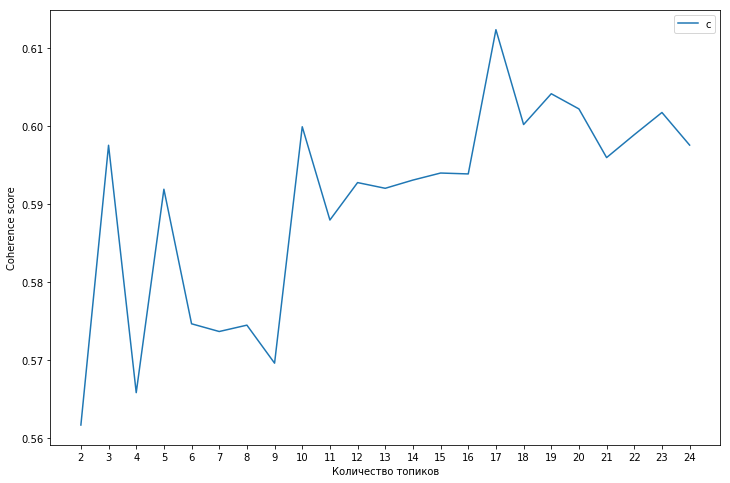

In [48]:
plt.figure(figsize=(12, 8))
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Количество топиков")
plt.ylabel("Coherence score")
plt.legend("coherence_values", loc='best')
plt.xticks(x, x)
plt.show()

### Гистограммы распределения количества слов

In [53]:
from collections import Counter
trigrammed_flat = [i for j in trigrammed for i in j]
count = Counter(trigrammed_flat)

In [67]:
count.most_common(20)

[('это', 92478),
 ('россии', 39142),
 ('также', 30634),
 ('которые', 21363),
 ('году', 20882),
 ('который', 20520),
 ('года', 18219),
 ('время', 17188),
 ('сша', 16592),
 ('читайте_также', 16022),
 ('однако', 15574),
 ('просто', 14238),
 ('украины', 13277),
 ('сегодня', 12895),
 ('человек', 12774),
 ('пока', 12671),
 ('очень', 12549),
 ('заявил', 11553),
 ('нашли_опечатку', 11487),
 ('выделите_е', 11486)]

In [77]:
counts = np.array(list(count.values()))
np.percentile(counts, 95)

58.0

In [83]:
sum(counts <= 5)

348601

95% слов встречаются меньше 58 раз. 348 тысяч слов встречаются меньше 6 раз. Это всё надо будет качественно почистить.

In [85]:
counts = counts[counts < 60]
counts = counts[counts >= 5]

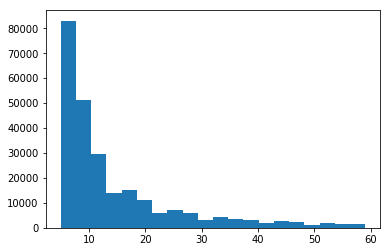

In [86]:
plt.hist(counts, bins=20);